<a href="https://colab.research.google.com/github/victorm0202/temas_selectos_CD/blob/main/NLP_text_pipeline_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An NLP pipeline for prediction models 

(adapted from Delip Rao et al. 2019)

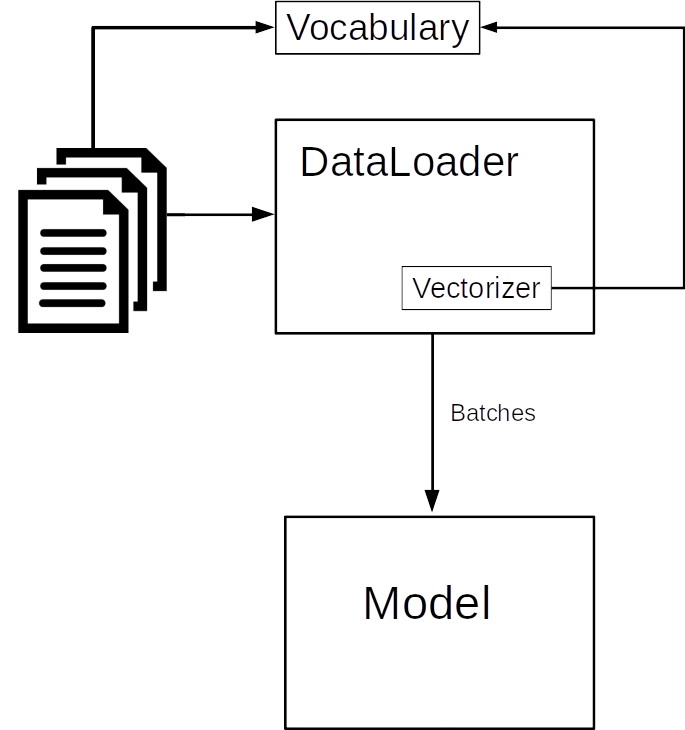

In [ ]:
import IPython.display as ipd
ipd.Image("nlp_pipeline.png", width=600)

# Example: classifying Yelp reviews

## Imports

In [ ]:
from my_classes import Vocabulary, MyVectorizer
import tqdm

In [ ]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=25,
    model_state_file='model.pth',
    review_csv='data/yelp/reviews_with_splits_lite.csv',
    # review_csv='data/yelp/reviews_with_splits_full.csv',
    save_dir='model_storage/ch3/yelp/',
    vectorizer_file='vectorizer.json',
    # No Model hyper parameters
    # Training hyper parameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

Expanded filepaths: 
	model_storage/ch3/yelp/vectorizer.json
	model_storage/ch3/yelp/model.pth
Using CUDA: False


## The Dataset

Reviews of restaurants into 1 to 4 stars. 
- Negative review: 1-2
- Positive review: 3-4

In [ ]:
review_df = pd.read_csv(args.review_csv)
train_review_df = review_df[review_df.split=='train']

In [ ]:
train_review_df.head()

,category,text,split
0,negative,terrible place to work for i just heard a stor...,train
1,negative,"hours , minutes total time for an extremely s...",train
2,negative,my less than stellar review is for service . w...,train
3,negative,i m granting one star because there s no way t...,train
4,negative,the food here is mediocre at best . i went aft...,train


## Vocabulary and vectorizer

In [ ]:
vectorizer = MyVectorizer.from_dataframe(train_review_df)

In [ ]:
ind = 1
row = train_review_df.iloc[ind]
review_vector = vectorizer.vectorize(row.text)
rating_index = vectorizer.category_vocab.lookup_token(row.category)

In [ ]:
rating_index

0

In [ ]:
#np.max(review_vector)
vectorizer.category_vocab.lookup_index(rating_index)

'negative'

In [ ]:
review_vector

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
vectorizer.text_vocab.lookup_token('hotel')

607

In [ ]:
vectorizer.text_vocab.lookup_index(1000)

'human'

## A class for this dataset

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (MyVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, MyVectorizer.from_dataframe(train_review_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            review_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of MyVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return MyVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.text)

        rating_index = \
            self._vectorizer.category_vocab.lookup_token(row.category)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  

## The DataLoader

In [ ]:
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: ReviewClassifier

In [ ]:
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,)
        """
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

## Training Routine

### Helper functions

In [ ]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### General utilities

In [ ]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work

In [ ]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=25,
    model_state_file='model.pth',
    review_csv='data/yelp/reviews_with_splits_lite.csv',
    # review_csv='data/yelp/reviews_with_splits_full.csv',
    save_dir='model_storage/ch3/yelp/',
    vectorizer_file='vectorizer.json',
    # No Model hyper parameters
    # Training hyper parameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch3/yelp/vectorizer.json
	model_storage/ch3/yelp/model.pth
Using CUDA: False


### Initializations

In [ ]:
if args.reload_from_files:
    # training from a checkpoint
    print("Loading dataset and vectorizer")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv, args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    # create dataset and vectorizer
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)    
vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features=len(vectorizer.text_vocab))

Loading dataset and creating vectorizer


### Training loop

In [ ]:
classifier = classifier.to(args.device)

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, 
                                  acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/306 [00:00<?, ?it/s]

split=val:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [ ]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 0.214
Test Accuracy: 91.81


### Inference

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [ ]:
def predict_rating(review, classifier, vectorizer, decision_threshold=0.5):
    """Predict the rating of a review
    
    Args:
        review (str): the text of the review
        classifier (ReviewClassifier): the trained model
        vectorizer (MyVectorizer): the corresponding vectorizer
        decision_threshold (float): The numerical boundary which separates the rating classes
    """
    review = preprocess_text(review)
    
    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))
    
    probability_value = F.sigmoid(result).item()
    index = 1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.category_vocab.lookup_index(index)

In [ ]:
test_review = "I do not know what to say about this book"
#test_review = "I really don't like this book"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold=0.5)
print("{} -> {}".format(test_review, prediction))

I do not know what to say about this book -> negative


### Interpretability

In [ ]:
classifier.fc1.weight.shape

torch.Size([1, 7326])

In [ ]:
# Sort weights
fc1_weights = classifier.fc1.weight.detach()[0]
_, indices = torch.sort(fc1_weights, dim=0, descending=True)
indices = indices.numpy().tolist()

# Top 20 words
print("Influential words in Positive Reviews:")
print("--------------------------------------")
for i in range(20):
    print(vectorizer.text_vocab.lookup_index(indices[i]))
    
print("====\n\n\n")

# Top 20 negative words
print("Influential words in Negative Reviews:")
print("--------------------------------------")
indices.reverse()
for i in range(20):
    print(vectorizer.text_vocab.lookup_index(indices[i]))

Influential words in Positive Reviews:
--------------------------------------
delicious
fantastic
pleasantly
amazing
great
vegas
excellent
yum
perfect
awesome
ngreat
yummy
love
bomb
solid
pleased
wonderful
chinatown
notch
deliciousness
====



Influential words in Negative Reviews:
--------------------------------------
worst
mediocre
bland
horrible
meh
awful
rude
terrible
tasteless
overpriced
disgusting
unacceptable
poorly
slowest
unfriendly
nmaybe
disappointing
disappointment
downhill
underwhelmed
